In [1]:
# import necessary modules
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import stats
from scipy.special import erfc
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import random
import pickle
import copy
from src.codonTable import codonTable
from src.codonUtils import utils
from src.thunderflask import thunderflask
from src.bacteria import strain

sns.set_context("paper")
# get fast fail table
ff_path = '/home/jonathan/Dropbox/Lab/Fast Fail/Manuscript/Isaac-pickle-jar/FFpickles/'
with open(ff_path+'ff20_table.pickle', 'rb') as handle:
    fftable = codonTable(table=pickle.load(handle))
# get ff16 table
with open(ff_path+'ff16_table.pickle', 'rb') as handle:
    ff16_table = codonTable(table=pickle.load(handle))
# get reductionist code 
### to fill in ###

# get reduct15 code
### to fill in ###

# get random table
with open('res/random_table_manuscript.pickle', 'rb') as handle:
    rand = codonTable(table=pickle.load(handle))
# get standard code
sc = codonTable()  
# get colorado code
col = codonTable(table=utils.coloradoTable)

# define colors
orange = '#ef6c00'
blue = '#2196f3'
green = '#008000'

### Generate Random Tables

In [5]:
# define number of trials to run
N = 1000000
# preallocate memory for statistics
silencicities = np.zeros(N)
mutabilities = np.zeros(N)
# perform N trials
for i in tqdm(range(N)):
    # generage graph
    ct = utils.randomTable(wobble_rule='unrestricted')
    silencicities[i] = utils.silencicity(ct)
    mutabilities[i] = utils.mutability(ct)


100%|██████████| 1000000/1000000 [13:09<00:00, 1265.92it/s]


NameError: name 'rand_silencicities' is not defined

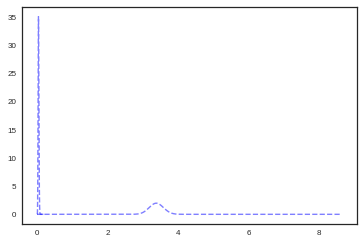

In [12]:
# perform fitting for two distributions
def fitter(array):
    # fit data
    s, loc, scale = stats.lognorm.fit(array)
    x = np.linspace(0, 2*max(array), 1000)
    pdf_fit = stats.lognorm.pdf(x, s, loc=loc, scale=scale)
    params = [s, loc, scale]
    plt.plot(x, pdf_fit, '--b', alpha=0.5, label='Fit')
    return x, pdf_fit, params
x_silence, pdf_silence, param_silence = fitter(silencicities)
x_mutate, pdf_mutate, param_mutate = fitter(mutabilities)

In [13]:
# pickle data for data permanence
to_dump = [silencicities, x_silence, pdf_silence, param_silence,
           mutabilities, x_mutate, pdf_mutate, param_mutate]
with open('res/fig1d.pickle', 'wb') as handle:
    pickle.dump(to_dump, handle)

## Figure 1: Genetic Codes Can Be Optimized for Desired Evolutionary Dynamics 

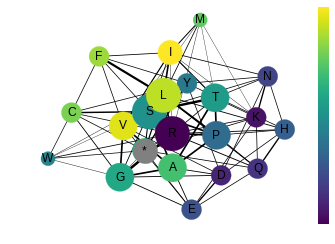

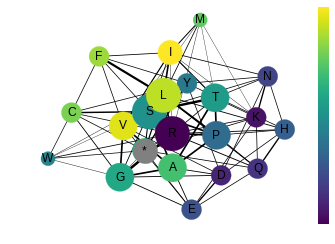

In [11]:
################
# Figures 1a-c #
################

# plot and save some shiznit
path = '/home/jonathan/Lab/Fast Fail/Figures/Figure 1/'
#rand.plotGraph(filename=path+'rand_graph.svg')
sc.plotGraph()#filename=path+'sc_graph.svg')
#col.plotGraph(filename=path+'col_graph.svg')

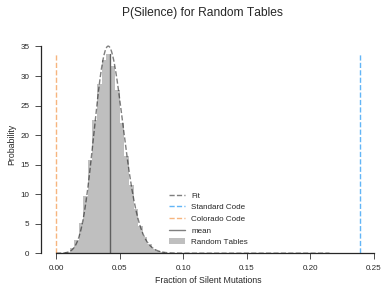

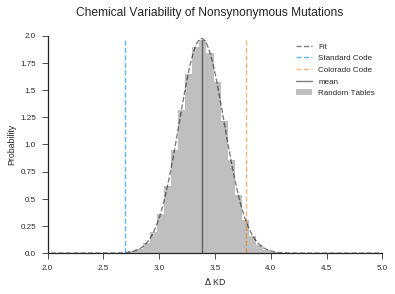

In [34]:
################
# Figures 1d-e #
################

# get data from pickle
with open('res/fig1d.pickle', 'rb') as handle:
    [silencicities, x_silence, pdf_silence, param_silence,
    mutabilities, x_mutate, pdf_mutate, param_mutate] = pickle.load(handle)
    
# Silencicity

# control aesthetics
sns.set_style('white')
sns.set_style('ticks')

# faster version of Silence plot: for when the values have already been calculated
#weights = np.ones(len(silencicities))/len(silencicities)
n, bins, patches = plt.hist(silencicities, 30, normed=1, #weights=weights,
                            color='grey', alpha=0.5, label='Random Tables')
plt.suptitle('P(Silence) for Random Tables')
plt.xlabel('Fraction of Silent Mutations')
plt.ylabel('Probability')
# fit data
def plotfit(x, pdf_fit):
    plt.plot(x, pdf_fit, '--k', alpha=0.5, label='Fit')
    return pdf_fit
plotfit(x_silence, pdf_silence)
#plt.xscale('log')
# define function for plotting individual lines given codonDict
def silentLiner(table, n, color, alpha, label):
    # calculate silencicities
    Silencicity = utils.silencicity(table.codonDict)
    Xs = np.ones(100)*Silencicity
    Ys = np.linspace(0, max(n), len(Xs))
    plt.plot(Xs, Ys, '--', color=color, alpha=alpha, label=label)
# plot line showing Standard Code
silentLiner(sc, n, blue, 0.7, 'Standard Code')
# plot line showing colorado code
silentLiner(col, n, orange, 0.5, 'Colorado Code')
#plot line showing random table
value = silencicities.mean()
Xs = np.ones(100)*value
Ys = np.linspace(0, max(n), len(Xs))
plt.plot(Xs, Ys, '-', color='black', alpha=0.5, label='mean')
#plt.xlim([0, 0.25])
fig = plt.gcf()
ax = plt.gca()
#h, l = ax.get_legend_handles_labels()
#h = [h[-1], h[0], h[1]]
#l = [l[-1], l[0], l[1]]
ax.legend()#h, l)
sns.despine(trim=True)
#plt.savefig('/home/jonathan/Dropbox/Lab/Fast Fail/Figures/Figure 1/silencicity.svg', bbox_inches='tight')
plt.show()

# Mutability

# faster version of Silence plot: for when the values have already been calculated
#weights = np.ones(len(silencicities))/len(silencicities)
n, bins, patches = plt.hist(mutabilities, 30, normed=1, #weights=weights,
                            color='grey', alpha=0.5, label='Random Tables')
plt.suptitle('Chemical Variability of Nonsynonymous Mutations')
plt.xlabel(r'$\Delta$ KD')
plt.ylabel('Probability')
# fit data
plotfit(x_mutate, pdf_mutate)
#plt.xscale('log')
# define function for plotting individual lines given codonDict
def silentLiner2(table, n, color, alpha, label):
    # calculate silencicities
    mutability = utils.mutability(table.codonDict)
    Xs = np.ones(100)*mutability
    Ys = np.linspace(0, max(n), len(Xs))
    plt.plot(Xs, Ys, '--', color=color, alpha=alpha, label=label)
# plot line showing Standard Code
silentLiner2(sc, n, blue, 0.7, 'Standard Code')
# plot line showing colorado code
silentLiner2(col, n, orange, 0.5, 'Colorado Code')
#plot line showing random table
value = mutabilities.mean()
Xs = np.ones(100)*value
Ys = np.linspace(0, max(n), len(Xs))
plt.plot(Xs, Ys, '-', color='black', alpha=0.5, label='mean')
# format ticks
loc, __ = plt.yticks()
ylabels = ['{0}'.format(num/4) for num in range(9)]
plt.yticks(loc, ylabels)
fig = plt.gcf()
ax = plt.gca()
#h, l = ax.get_legend_handles_labels()
#h = [h[-1], h[0], h[1]]
#l = [l[-1], l[0], l[1]]
ax.legend()#h, l
sns.plt.ylim(0,2)
sns.plt.xlim(2,5)
sns.despine()
plt.savefig('/home/jonathan/Dropbox/Lab/Fast Fail/Figures/Figure 1/mutability.svg', bbox_inches='tight')
plt.show()

In [28]:
# calculate p value and 1 in foo of standard table silencicity
[s, loc, scale] = param_silence
z = (utils.silencicity(sc.codonDict) - loc) / scale
sig = np.log(z)/s
p = erfc(sig/np.sqrt(2))

oneInFoo = 1 / p
print('1 in {:.2e}'.format(oneInFoo))

1 in 1.01e+24


In [27]:
ticks = ['{0}'.format(num/4) for num in range(8)]
ticks

['0.0', '0.25', '0.5', '0.75', '1.0', '1.25', '1.5', '1.75']

In [50]:
sc_copy = copy.deepcopy(utils.standardTable)
aa_s = utils.residues
block_array = []
# loop over amino acids
for aa in aa_s:
    # get the block associated with that amino acid
    block = dict((key,value) for key, value in sc_copy.items() if value == aa)
    # store in block array
    block_array.append(block)

# loop over blocks
choices = []
for i, block in enumerate(block_array):
    # get choice
    choice = random.choice(list(block))
    # loop over codons in block
    for codon in list(block):
        # set all non-choice codons in block to stop
        if codon != choice: block[codon] = '*'
    # append choice to choices
    choices.append(choice)
print(block_array[3])

{'CUG': '*', 'UUG': '*', 'CUC': '*', 'UUA': 'L', 'CUU': '*', 'CUA': '*'}


## Figure 2: Fast Fail Genetic Codes Can Hinder Evolution

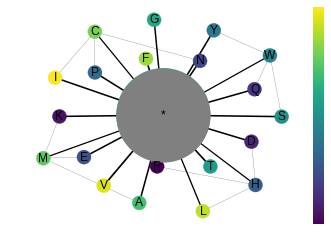

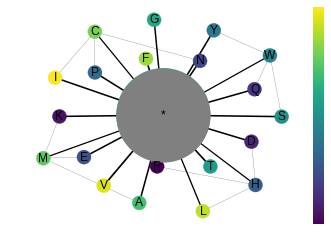

In [10]:
################
# Figures 2a-c #
################

# plot and save some shiznit
path = '/home/jonathan/Lab/Fast Fail/Figures/Figure 2/'
#fftable.codonTable.to_csv(path+'fftable.csv')
fftable.plotGraph()#filename=path+'ff_graph.svg')
#ff16_table.codonTable.to_csv(path+'ff16.csv')
#f16_table.plotGraph(filename=path+'ff16_graph.svg')
# reductionist.plotGraph(weightingFxn=weighter, filename=path+'reductionist_graph.svg')
# reduct16.plotGraph(weightingFxn=weighter, filename=path+'reduct16_graph.svg')

In [15]:
ff16_table.codonGraph.edges(data=True)

[('*', 'T', {'weight': 4.018775720164608e-06}),
 ('*', 'G', {'weight': 4.82253086419753e-05}),
 ('*', 'R', {'weight': 0.75}),
 ('*', 'K', {'weight': 0.006944444444444444}),
 ('*', 'V', {'weight': 0.08333333333333333}),
 ('*', 'F', {'weight': 2.325680393613777e-09}),
 ('*', 'D', {'weight': 2.790816472336533e-08}),
 ('*', 'Q', {'weight': 3.3489797668038396e-07}),
 ('*', 'A', {'weight': 0.75}),
 ('*', 'S', {'weight': 0.75}),
 ('*', 'E', {'weight': 0.75}),
 ('*', 'L', {'weight': 0.75}),
 ('*', 'P', {'weight': 4.5073244110329455e-19}),
 ('*', 'Y', {'weight': 0.75}),
 ('*', 'N', {'weight': 0.75}),
 ('*', 'I', {'weight': 0.75})]